# Домашнее задание

##  Срок выполнения 13.11.2024

### Первая часть

Задание будет простым: нужно реализовать функции для поэлементного сложения двух матриц:

    1) На чистом python
    2) python + @njit
    3) numpy
    4) numpy + @njit
    5) @cuda.jit
    
Также необходимо замерить время выполнения


In [1]:
from numba import jit, njit, cuda, vectorize, float64, float32, cuda, guvectorize, int32
import numpy as np
from numpy import testing
import math

In [7]:
def mat_sum(x, y):
    x_rows, x_cols = x.shape
    y_rows, y_cols = y.shape
    z = np.zeros(x_rows * y_cols).reshape(x_rows, y_cols)
    for i in range(x_rows):
        for j in range(x_cols):
            z[i][j] = x[i][j] + y[i][j]
    return z

@njit
def mat_sum_numba(x, y):
    x_rows, x_cols = x.shape
    y_rows, y_cols = y.shape
    z = np.zeros(x_rows * y_cols).reshape(x_rows, y_cols)
    for i in range(x_rows):
        for j in range(x_cols):
            z[i][j] = x[i][j] + y[i][j]
    return z


def mat_sum_numpy(x, y):
    return x + y

@njit(parallel=True)
def mat_sum_numpy_numba(x, y):
    return x + y

@cuda.jit
def mat_sum_cuda(x, y, z):
    i, j = cuda.grid(2)
    z[i, j] = x[i][j] + y[i][j]

In [3]:
x_mat = np.random.random_sample(90000).reshape(300, 300)
y_mat = np.random.random_sample(90000).reshape(300, 300)

In [4]:
testing.assert_almost_equal(mat_sum(x_mat, y_mat), mat_sum_numpy(x_mat, y_mat), decimal=2)

In [ ]:
%timeit mat_sum(x_mat, y_mat)

48.4 ms ± 10.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit mat_sum_numpy(x_mat, y_mat)

39.9 μs ± 1.93 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
%timeit mat_sum_numba(x_mat, y_mat)

46.3 μs ± 492 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
%timeit mat_sum_numpy_numba(x_mat, y_mat)

41.3 μs ± 3.13 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [5]:
threadsperblock = (16, 16)
blockspergrid_x = int(math.ceil(x_mat.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(y_mat.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

d_x = cuda.to_device(x_mat)
d_y = cuda.to_device(y_mat)
z = np.zeros(x_mat.shape[0] * y_mat.shape[1]).reshape(x_mat.shape[0], y_mat.shape[1])
d_z = cuda.to_device(z)

In [9]:
%timeit mat_sum_cuda[blockspergrid, threadsperblock](d_x, d_y, d_z)

56.3 µs ± 1.56 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### Вторая часть

Попробуйте для параллельного расчета preprocess_array разные комбинации количетва ядер и размера батча. Постройте график зависмости времени расчета (в простом варианте можно несколько графиков при фиксации одного из параметров).

In [ ]:
from joblib import Parallel, delayed, cpu_count, parallel_backend
import pandas as pd
import time

In [ ]:
x = np.random.random_sample(2_000_000)
vector = np.random.random_sample(100)

In [ ]:
def preprocess_one(val):
    val = np.sum(np.multiply(vector, val))
    return val ** 2


def preprocess_array(values):
    return [preprocess_one(val) for val in values]

In [ ]:
def preprocess_array_time_test(x, batch_size, n_jobs):
    batches = [x[i:i+batch_size] for i in range(0, len(x), batch_size)]

    with Parallel(n_jobs=n_jobs, backend="loky") as parallel:
        results = parallel(delayed(preprocess_array)(val) for val in batches)

In [ ]:
grid = []

for n_jobs in range(2, 9, 2):
    grid.append((2000, n_jobs))

for batch_size in range(2000, 16001, 4000):
    for n_jobs in range(2, 9, 2):
        grid.append((batch_size, n_jobs))

for batch_size in range(20000, 200001, 20000):
    for n_jobs in range(2, 9, 2):
        grid.append((batch_size, n_jobs))

In [ ]:
def measure_time(func, *args, **kwargs):
    start_time = time.time()
    func(*args, **kwargs)
    end_time = time.time()
    return end_time - start_time

In [ ]:
results = pd.DataFrame(columns=['batch_size', 'n_jobs', 'avg_time'])
num_runs = 10

for batch_size, n_jobs in grid:
    times = []
    for _ in range(num_runs):
        execution_time = measure_time(preprocess_array_time_test, x, batch_size, n_jobs)
        times.append(execution_time)

    avg_time = np.mean(times)

    new_row = {
        'batch_size': batch_size,
        'n_jobs': n_jobs,
        'avg_time': avg_time
    }
    results = pd.concat([results, pd.DataFrame([new_row])], ignore_index=True)

In [ ]:
optimal_params = results.loc[results['avg_time'].idxmin()]

batch_size = optimal_params['batch_size']
n_jobs = optimal_params['n_jobs']
min_avg_time = optimal_params['avg_time']

print(f"Оптимальные параметры:")
print(f"Batch size: {batch_size}, Number of jobs: {n_jobs}, Average time: {min_avg_time:.4f} seconds")

Оптимальные параметры:
Batch size: 12000, Number of jobs: 8, Average time: 3.8387 seconds


### Графики усредненного времени в зависимости от размера батчей для разных n_jobs

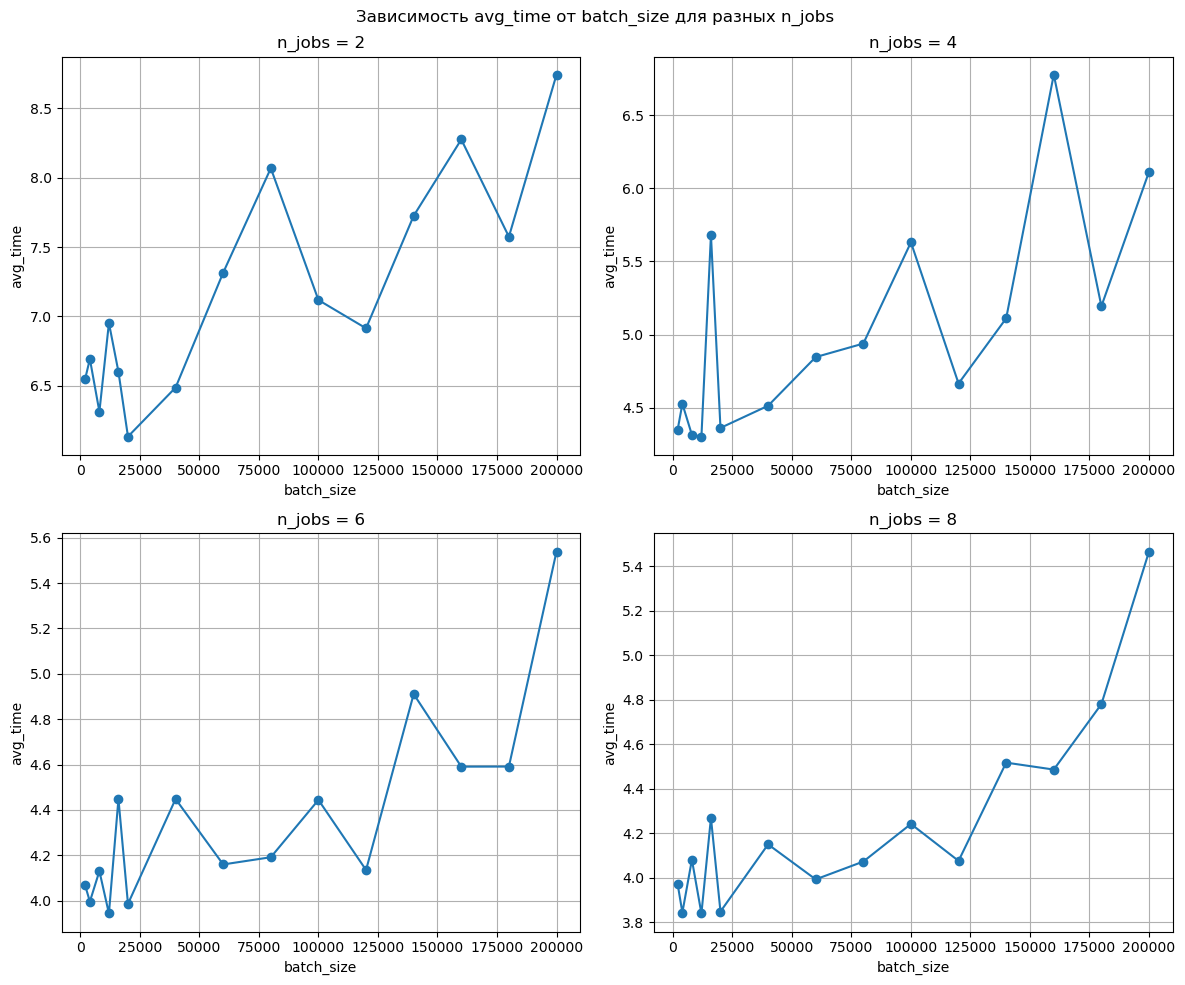

In [ ]:
import matplotlib.pyplot as plt


n_jobs_values = results['n_jobs'].unique()

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Зависимость avg_time от batch_size для разных n_jobs')

axes = axes.flatten()

for i, n_jobs in enumerate(n_jobs_values):
    data = results[results['n_jobs'] == n_jobs]

    data = data.sort_values('batch_size')

    axes[i].plot(data['batch_size'], data['avg_time'], marker='o')
    axes[i].set_title(f'n_jobs = {n_jobs}')
    axes[i].set_xlabel('batch_size')
    axes[i].set_ylabel('avg_time')
    axes[i].grid(True)

for j in range(i+1, 4):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### График усредненного времени в зависимости от размера батчей (логарифмическая шкала)

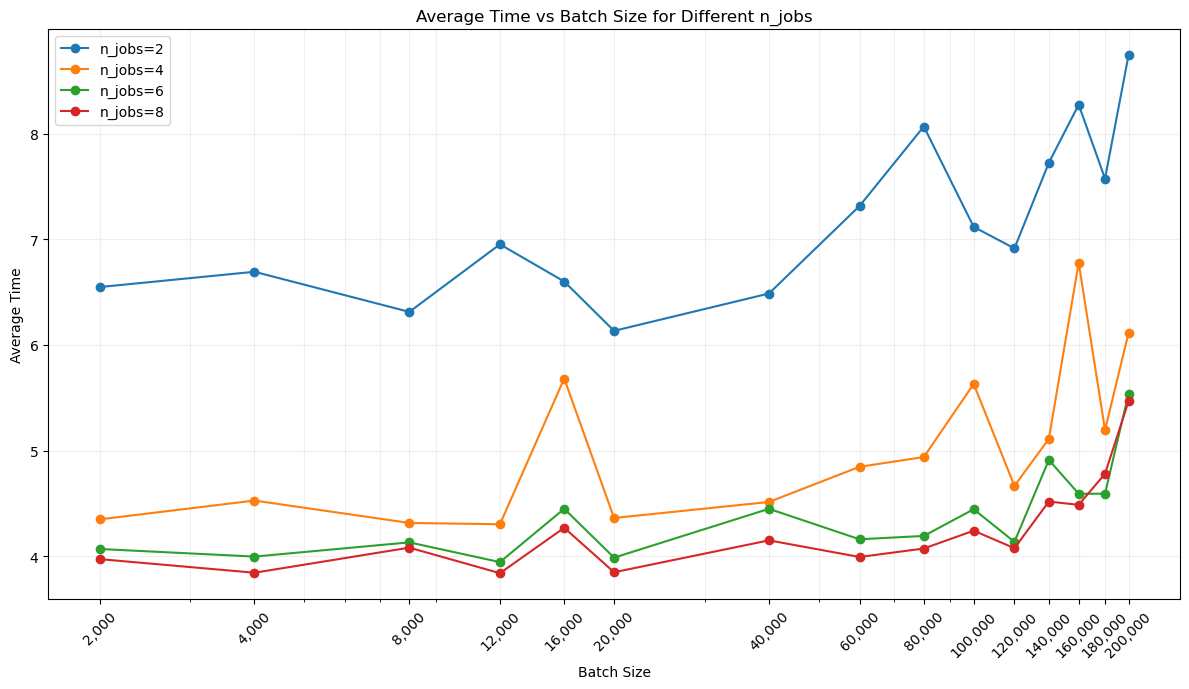

In [ ]:
plt.figure(figsize=(12, 7))

for n_jobs in results['n_jobs'].unique():
    data = results[results['n_jobs'] == n_jobs].sort_values('batch_size')
    plt.plot(data['batch_size'], data['avg_time'], marker='o', label=f'n_jobs={n_jobs}')

plt.xscale('log')

ticks = [2000] + list(range(4000, 16001, 4000)) + list(range(20000, 220000, 20000))
plt.xticks(ticks, [str(x) for x in ticks], rotation=45)

plt.xlabel('Batch Size')
plt.ylabel('Average Time')
plt.title('Average Time vs Batch Size for Different n_jobs')

plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.tight_layout()
plt.show()